Experiment GPU info：

In [ ]:
# this code will present the GPU info of your device
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May  6 16:18:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Standard linear dataloader(default setting of pytorch,dataloader):

In [ ]:
import time
from typing import List

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score

# data params
ROW_LIMIT = None # for quicker testing
NUM_TEST_ROWS = 500000
LABEL_COLUMN = 0
FEATURE_COLUMNS = list(range(1, 22)) # low-level features only
# please change this file position as your position if you want try this code by yourself.
# Also make sure you download the HIGGS.csv.gz dataset. the download url is: http://archive.ics.uci.edu/ml/datasets/HIGGS
FILE_NAME = '/content/drive/MyDrive/higg_data/HIGGS.csv.gz' 
GPU = True

# hyperparams
BATCH_SIZE = 16384
NUM_EPOCHS = 10

def load_data(file_name: str, test_rows: int, feature_columns: List[int], label_column: int, row_limit: int):
    # Load data from disk into train and test tensors
    # load csv file
    data = pd.read_csv(file_name, header=None, dtype='float32', nrows=row_limit)

    features = torch.from_numpy(data.loc[:, feature_columns].reset_index(drop=True).values)
    labels = torch.from_numpy(data.loc[:, label_column].reset_index(drop=True).values)

    train_x = features[:-test_rows]
    train_y = labels[:-test_rows]

    test_x = features[-test_rows:]
    test_y = labels[-test_rows:]

    return train_x, train_y, test_x, test_y


# load data and split it to train and test set
train_x, train_y, test_x, test_y = load_data(file_name=FILE_NAME, test_rows=NUM_TEST_ROWS,
            feature_columns=FEATURE_COLUMNS, label_column=LABEL_COLUMN, row_limit=ROW_LIMIT)

def create_model(gpu: bool=True):
    """
    Create a simple PyTorch neural net for benchmark use of depth 4.(linear model)
    """
    dropout_rate = 0.5
    hidden_units = 300
    model = nn.Sequential(
        nn.Linear(len(FEATURE_COLUMNS), hidden_units),
        nn.Tanh(),
        nn.Dropout(p=dropout_rate), 
        nn.Linear(hidden_units, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, 1),
        nn.Sigmoid()
        )
    if gpu: # move model onto the GPU
        model = model.cuda()
    return model

def train_for_n_epochs(model: nn.Module, train_dataloader: DataLoader, test_x: torch.Tensor, test_y: torch.Tensor, epochs: int, name: str, log_every_n_steps=100, eval_every_n_steps=100, gpu: bool=True):
    # Train a pytorch model for a set number of epochs, using a given dataloader.
    optimizer = torch.optim.Adam(params=model.parameters())
    loss_fn = nn.BCELoss(reduction='mean')

    # log to tensorboard
    writer = SummaryWriter(comment=name)

    global_step = 0

    if gpu: # move test set on to GPU
        test_x = test_x.cuda()
        test_y = test_y.cuda()

    for epoch in range(epochs):
        for x_batch, y_batch in train_dataloader:
            if gpu: # move batches from RAM into GPU memory
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
            y_pred = model(x_batch)

             # zero the parameter gradients
            optimizer.zero_grad()

            loss = loss_fn(y_pred.squeeze(), y_batch)

            if global_step % log_every_n_steps == log_every_n_steps - 1:
                    writer.add_scalar('Loss/train', loss, global_step)
                    writer.add_scalar('Epoch', epoch, global_step)
                    roc_auc = roc_auc_score(y_batch.cpu().numpy(), y_pred.cpu().detach().numpy())
                    writer.add_scalar('ROC_AUC/train', roc_auc, global_step)

            loss.backward()
            optimizer.step()

            if global_step % eval_every_n_steps == eval_every_n_steps - 1:
                    test_y_pred = model(test_x)
                    test_loss = loss_fn(test_y_pred.squeeze(), test_y)
                    writer.add_scalar('Loss/test', test_loss, global_step)
                    test_roc_auc = roc_auc_score(test_y.cpu().numpy(), test_y_pred.cpu().detach().numpy())
                    writer.add_scalar('ROC_AUC/test', test_roc_auc, global_step)

            global_step += 1
        # print the ralated data for each epoch
        print(f'Epoch {epoch} done. ')
        print(f'Train Loss of this epoch is {loss}. ')
        print(f'Test Loss of this epoch is {test_loss}. ')
        print(f'ROC_AUC score of this epoch is {roc_auc}. ')
        print(f'Test ROC_AUC score of this epoch is {test_roc_auc}. ')


data_set = TensorDataset(train_x, train_y)
default_train_batches = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=False)

# standard dataloader benchmark
model = create_model(gpu=GPU)
start = time.perf_counter()
train_for_n_epochs(model=model, train_dataloader=default_train_batches, test_x=test_x, test_y=test_y, epochs=NUM_EPOCHS, name='default_data_loader', gpu=GPU)
default_elapsed_seconds = time.perf_counter() - start

print(f'Standard dataloader: {default_elapsed_seconds/NUM_EPOCHS:.2f}s/epoch.')

Parallel dataloader by using the num_workers parameters: (The max number of num_workers should be the core number of processer, here is 12)

In [ ]:
import time
from typing import List

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score

# data params
ROW_LIMIT = None # for quicker testing
NUM_TEST_ROWS = 500000
LABEL_COLUMN = 0
FEATURE_COLUMNS = list(range(1, 22)) # low-level features only
# please change this file position as your position if you want try this code by yourself.
# Also make sure you download the HIGGS.csv.gz dataset. the download url is: http://archive.ics.uci.edu/ml/datasets/HIGGS
FILE_NAME = '/content/drive/MyDrive/higg_data/HIGGS.csv.gz'
GPU = True

# hyperparams
BATCH_SIZE = 16384
NUM_EPOCHS = 10

def load_data(file_name: str, test_rows: int, feature_columns: List[int], label_column: int, row_limit: int):
    # Load data from disk into train and test tensors
    # load csv file
    data = pd.read_csv(file_name, header=None, dtype='float32', nrows=row_limit)

    features = torch.from_numpy(data.loc[:, feature_columns].reset_index(drop=True).values)
    labels = torch.from_numpy(data.loc[:, label_column].reset_index(drop=True).values)

    train_x = features[:-test_rows]
    train_y = labels[:-test_rows]

    test_x = features[-test_rows:]
    test_y = labels[-test_rows:]

    return train_x, train_y, test_x, test_y


# load data
train_x, train_y, test_x, test_y = load_data(file_name=FILE_NAME, test_rows=NUM_TEST_ROWS,
            feature_columns=FEATURE_COLUMNS, label_column=LABEL_COLUMN, row_limit=ROW_LIMIT)

def create_model(gpu: bool=True):
    """
    Create a simple PyTorch neural net for benchmark use of depth 4.(linear model)
    """
    dropout_rate = 0.5
    hidden_units = 300
    model = nn.Sequential(
        nn.Linear(len(FEATURE_COLUMNS), hidden_units),
        nn.Tanh(),
        nn.Dropout(p=dropout_rate), 
        nn.Linear(hidden_units, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, 1),
        nn.Sigmoid()
        )
    if gpu: # move model onto the GPU
        model = model.cuda()
    return model

def train_for_n_epochs(model: nn.Module, train_dataloader: DataLoader, test_x: torch.Tensor, test_y: torch.Tensor, epochs: int, name: str, log_every_n_steps=100, eval_every_n_steps=100, gpu: bool=True):
    # Train a pytorch model for a set number of epochs, using a given dataloader.
    optimizer = torch.optim.Adam(params=model.parameters())
    loss_fn = nn.BCELoss(reduction='mean')

    # log to tensorboard
    writer = SummaryWriter(comment=name)

    global_step = 0

    if gpu: # move test set on to GPU
        test_x = test_x.cuda()
        test_y = test_y.cuda()

    for epoch in range(epochs):
        for x_batch, y_batch in train_dataloader:
            if gpu: # move batches from RAM into GPU memory
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
            y_pred = model(x_batch)

             # zero the parameter gradients
            optimizer.zero_grad()

            loss = loss_fn(y_pred.squeeze(), y_batch)

            if global_step % log_every_n_steps == log_every_n_steps - 1:
                    writer.add_scalar('Loss/train', loss, global_step)
                    writer.add_scalar('Epoch', epoch, global_step)
                    roc_auc = roc_auc_score(y_batch.cpu().numpy(), y_pred.cpu().detach().numpy())
                    writer.add_scalar('ROC_AUC/train', roc_auc, global_step)

            loss.backward()
            optimizer.step()

            if global_step % eval_every_n_steps == eval_every_n_steps - 1:
                    test_y_pred = model(test_x)
                    test_loss = loss_fn(test_y_pred.squeeze(), test_y)
                    writer.add_scalar('Loss/test', test_loss, global_step)
                    test_roc_auc = roc_auc_score(test_y.cpu().numpy(), test_y_pred.cpu().detach().numpy())
                    writer.add_scalar('ROC_AUC/test', test_roc_auc, global_step)

            global_step += 1
        # print the ralated data for each epoch
        print(f'Epoch {epoch} done. ')
        print(f'Train Loss of this epoch is {loss}. ')
        print(f'Test Loss of this epoch is {test_loss}. ')
        print(f'ROC_AUC score of this epoch is {roc_auc}. ')
        print(f'Test ROC_AUC score of this epoch is {test_roc_auc}. ')


data_set = TensorDataset(train_x, train_y)


default_train_batches = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=12) # here set the num)workers size, max is your processer's core number.
# standard dataloader benchmark with parallel dataloader
model = create_model(gpu=GPU)
start = time.perf_counter()

train_for_n_epochs(model=model, train_dataloader=default_train_batches, test_x=test_x, test_y=test_y, epochs=NUM_EPOCHS, name='default_data_loader', gpu=GPU)

default_elapsed_seconds = time.perf_counter() - start
print(f'Standard dataloader: {default_elapsed_seconds/NUM_EPOCHS:.2f}s/epoch.')

Epoch 0 done. 
Train Loss of this epoch is 0.6079628467559814. 
Test Loss of this epoch is 0.6132058501243591. 
ROC_AUC score of this epoch is 0.7158152800663911. 
Test ROC_AUC score of this epoch is 0.7184675871571986. 
Epoch 1 done. 
Train Loss of this epoch is 0.5915617942810059. 
Test Loss of this epoch is 0.5971108675003052. 
ROC_AUC score of this epoch is 0.740213924566024. 
Test ROC_AUC score of this epoch is 0.743355252020446. 
Epoch 2 done. 
Train Loss of this epoch is 0.5855315327644348. 
Test Loss of this epoch is 0.5842191576957703. 
ROC_AUC score of this epoch is 0.7528997441442938. 
Test ROC_AUC score of this epoch is 0.7542665940716998. 
Epoch 3 done. 
Train Loss of this epoch is 0.5824646353721619. 
Test Loss of this epoch is 0.5798578262329102. 
ROC_AUC score of this epoch is 0.7572684480836669. 
Test ROC_AUC score of this epoch is 0.7590552297272881. 
Epoch 4 done. 
Train Loss of this epoch is 0.578047513961792. 
Test Loss of this epoch is 0.5766165852546692. 
ROC_AUC

Our custom fast dataloader:

In [ ]:
import torch

class FastTensorDataLoader:
    # Our custom fast dataloader:
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.

        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.

        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches


import time
from typing import List

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score

# data params
ROW_LIMIT = None # for quicker testing
NUM_TEST_ROWS = 500000
LABEL_COLUMN = 0
FEATURE_COLUMNS = list(range(1, 22)) # low-level features only
# please change this file position as your position if you want try this code by yourself.
# Also make sure you download the HIGGS.csv.gz dataset. the download url is: http://archive.ics.uci.edu/ml/datasets/HIGGS
FILE_NAME = '/content/drive/MyDrive/higg_data/HIGGS.csv.gz'
GPU = True

# hyperparams
BATCH_SIZE = 16384
NUM_EPOCHS = 10

def load_data(file_name: str, test_rows: int, feature_columns: List[int], label_column: int, row_limit: int):
    # Load data from disk into train and test tensors
    # load csv file
    data = pd.read_csv(file_name, header=None, dtype='float32', nrows=row_limit)

    features = torch.from_numpy(data.loc[:, feature_columns].reset_index(drop=True).values)
    labels = torch.from_numpy(data.loc[:, label_column].reset_index(drop=True).values)

    train_x = features[:-test_rows]
    train_y = labels[:-test_rows]

    test_x = features[-test_rows:]
    test_y = labels[-test_rows:]

    return train_x, train_y, test_x, test_y


# load data
train_x, train_y, test_x, test_y = load_data(file_name=FILE_NAME, test_rows=NUM_TEST_ROWS,
            feature_columns=FEATURE_COLUMNS, label_column=LABEL_COLUMN, row_limit=ROW_LIMIT)

def create_model(gpu: bool=True):
    """
    Create a simple PyTorch neural net for benchmark use of depth 4.(linear model)
    """
    dropout_rate = 0.5
    hidden_units = 300
    model = nn.Sequential(
        nn.Linear(len(FEATURE_COLUMNS), hidden_units),
        nn.Tanh(),
        nn.Dropout(p=dropout_rate), 
        nn.Linear(hidden_units, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, hidden_units),
        nn.Tanh(),
        nn.Linear(hidden_units, 1),
        nn.Sigmoid()
        )
    if gpu: # move model onto the GPU
        model = model.cuda()
    return model

def train_for_n_epochs(model: nn.Module, train_dataloader: DataLoader, test_x: torch.Tensor, test_y: torch.Tensor, epochs: int, name: str, log_every_n_steps=100, eval_every_n_steps=100, gpu: bool=True):
    # Train a pytorch model for a set number of epochs, using a given dataloader.
    optimizer = torch.optim.Adam(params=model.parameters())
    loss_fn = nn.BCELoss(reduction='mean')

    # log to tensorboard
    writer = SummaryWriter(comment=name)

    global_step = 0

    if gpu: # move test set on to GPU
        test_x = test_x.cuda()
        test_y = test_y.cuda()

    for epoch in range(epochs):
        for x_batch, y_batch in train_dataloader:
            if gpu: # move batches from RAM into GPU memory
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
            y_pred = model(x_batch)

             # zero the parameter gradients
            optimizer.zero_grad()

            loss = loss_fn(y_pred.squeeze(), y_batch)

            if global_step % log_every_n_steps == log_every_n_steps - 1:
                    writer.add_scalar('Loss/train', loss, global_step)
                    writer.add_scalar('Epoch', epoch, global_step)
                    roc_auc = roc_auc_score(y_batch.cpu().numpy(), y_pred.cpu().detach().numpy())
                    writer.add_scalar('ROC_AUC/train', roc_auc, global_step)

            loss.backward()
            optimizer.step()

            if global_step % eval_every_n_steps == eval_every_n_steps - 1:
                    test_y_pred = model(test_x)
                    test_loss = loss_fn(test_y_pred.squeeze(), test_y)
                    writer.add_scalar('Loss/test', test_loss, global_step)
                    test_roc_auc = roc_auc_score(test_y.cpu().numpy(), test_y_pred.cpu().detach().numpy())
                    writer.add_scalar('ROC_AUC/test', test_roc_auc, global_step)

            global_step += 1
        # print the ralated data for each epoch
        print(f'Epoch {epoch} done. ')
        print(f'Train Loss of this epoch is {loss}. ')
        print(f'Test Loss of this epoch is {test_loss}. ')
        print(f'ROC_AUC score of this epoch is {roc_auc}. ')
        print(f'Test ROC_AUC score of this epoch is {test_roc_auc}. ')

fast_train_batches = FastTensorDataLoader(train_x, train_y, batch_size=BATCH_SIZE, shuffle=False)

# improved dataloader benchmark
model = create_model(gpu=GPU)
start = time.perf_counter()

train_for_n_epochs(model=model, train_dataloader=fast_train_batches, test_x=test_x, test_y=test_y, epochs=NUM_EPOCHS, name='custom_data_loader', gpu=GPU)

fast_elapsed_seconds = time.perf_counter() - start

print(f'Custom dataloader: {fast_elapsed_seconds/NUM_EPOCHS:.2f}s/epoch.')

Epoch 0 done. 
Train Loss of this epoch is 0.6055893301963806. 
Test Loss of this epoch is 0.6127424836158752. 
ROC_AUC score of this epoch is 0.7167929512174092. 
Test ROC_AUC score of this epoch is 0.7192673333094572. 
Epoch 1 done. 
Train Loss of this epoch is 0.5908973813056946. 
Test Loss of this epoch is 0.5956502556800842. 
ROC_AUC score of this epoch is 0.7467932876746334. 
Test ROC_AUC score of this epoch is 0.7442526986665736. 
Epoch 2 done. 
Train Loss of this epoch is 0.5816768407821655. 
Test Loss of this epoch is 0.5838757753372192. 
ROC_AUC score of this epoch is 0.7509025806671255. 
Test ROC_AUC score of this epoch is 0.7546686411201347. 
Epoch 3 done. 
Train Loss of this epoch is 0.5769954323768616. 
Test Loss of this epoch is 0.579380452632904. 
ROC_AUC score of this epoch is 0.7576912490610902. 
Test ROC_AUC score of this epoch is 0.7596297054419396. 
Epoch 4 done. 
Train Loss of this epoch is 0.5759868621826172. 
Test Loss of this epoch is 0.576201856136322. 
ROC_AU

Draw the ralated graph:

Loss:

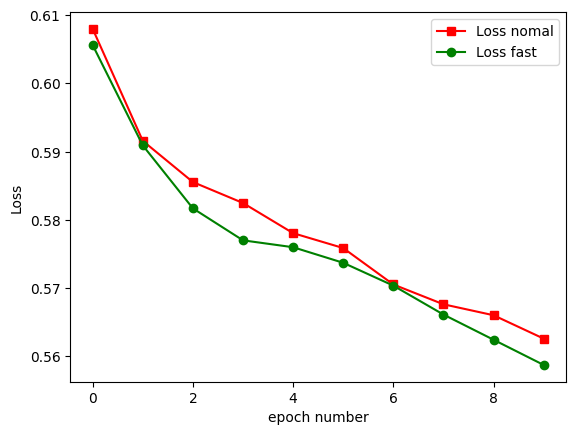

In [ ]:
import matplotlib.pyplot as plt

x = [0,1,2,3,4,5,6,7,8,9]
loss1 = [ 0.6079628467559814, 0.5915617942810059, 0.5855315327644348, 0.5824646353721619, 0.578047513961792, 0.5758658051490784, 0.5705307126045227, 0.5676287412643433, 0.5660244226455688, 0.5626027584075928]
loss2 = [0.6055893301963806,0.5908973813056946,0.5816768407821655,0.5769954323768616,0.5759868621826172,0.5737063884735107,0.5703610181808472,0.5661270618438721,0.5624366998672485,0.558746337890625]
plt.plot(x,loss1,'s-',color = 'r',label="Loss nomal")
plt.plot(x,loss2,'o-',color = 'g',label="Loss fast")
plt.xlabel("epoch number")
plt.ylabel("Loss")
plt.legend(loc = "best")
plt.show()

Test loss:

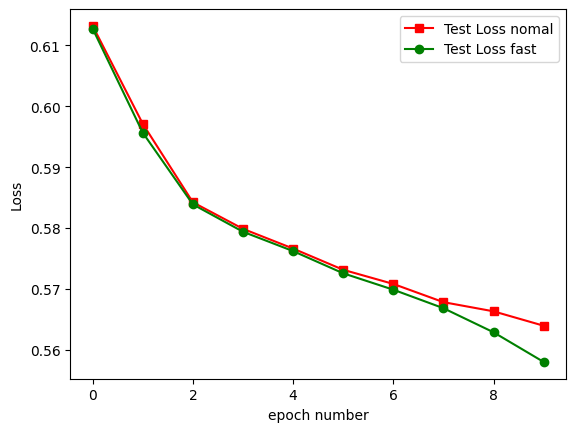

In [ ]:
import matplotlib.pyplot as plt

x = [0,1,2,3,4,5,6,7,8,9]
loss1 = [0.6132058501243591, 0.5971108675003052, 0.5842191576957703, 0.5798578262329102, 0.5766165852546692, 0.5731292366981506, 0.5708051919937134, 0.5678123831748962, 0.5663045048713684, 0.5639387369155884]
loss2 = [0.6127424836158752, 0.5956502556800842, 0.5838757753372192, 0.579380452632904, 0.576201856136322, 0.5725541710853577, 0.5698586106300354, 0.5668193697929382, 0.5628617405891418, 0.5579898953437805]
plt.plot(x,loss1,'s-',color = 'r',label="Test Loss nomal")
plt.plot(x,loss2,'o-',color = 'g',label="Test Loss fast")
plt.xlabel("epoch number")
plt.ylabel("Loss")
plt.legend(loc = "best")
plt.show()

ROC_AUC score：

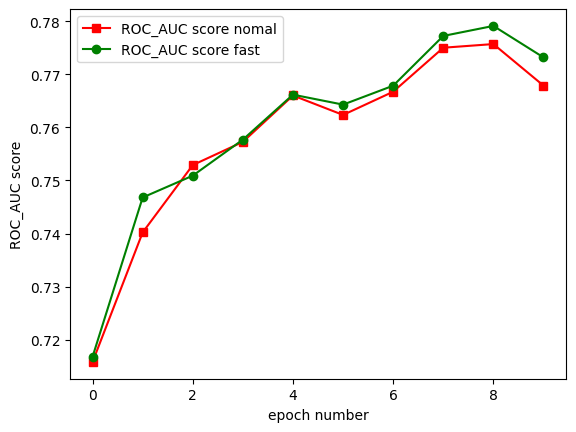

In [ ]:
import matplotlib.pyplot as plt

x = [0,1,2,3,4,5,6,7,8,9]
loss1 = [0.7158152800663911, 0.740213924566024, 0.7528997441442938, 0.7572684480836669, 0.7660034936356733, 0.7623422892622481, 0.7667150598686197, 0.7750039236980182, 0.7756918406105038, 0.7678650810165142]
loss2 = [0.7167929512174092, 0.7467932876746334, 0.7509025806671255, 0.7576912490610902, 0.7661618791652579, 0.7642843098154992, 0.7678506081492236, 0.7772231571201937, 0.779110117901501, 0.7731817315681752]
plt.plot(x,loss1,'s-',color = 'r',label="ROC_AUC score nomal")
plt.plot(x,loss2,'o-',color = 'g',label="ROC_AUC score fast")
plt.xlabel("epoch number")
plt.ylabel("ROC_AUC score")
plt.legend(loc = "best")
plt.show()

Test ROC_AUC score:

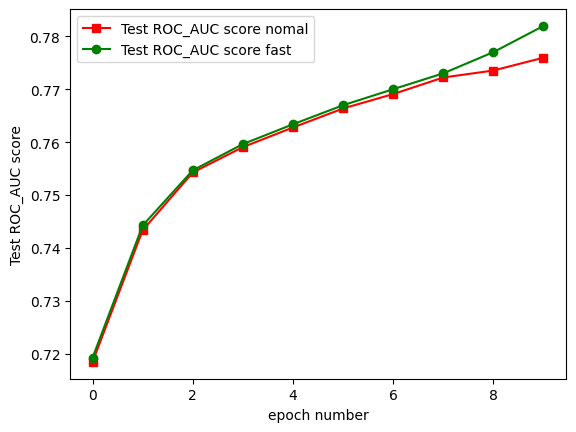

In [ ]:
import matplotlib.pyplot as plt

x = [0,1,2,3,4,5,6,7,8,9]
loss1 = [0.7184675871571986, 0.743355252020446, 0.7542665940716998, 0.7590552297272881, 0.7627653449121327, 0.766360613475832, 0.7690779870767855, 0.7722143805097588, 0.7735307811903497, 0.7759552693491544]
loss2 = [0.7192673333094572, 0.7442526986665736, 0.7546686411201347, 0.7596297054419396, 0.7633706132251237, 0.7669742825723509, 0.769999627886682, 0.7729983538711064, 0.777004857678179, 0.7819573133565396]
plt.plot(x,loss1,'s-',color = 'r',label="Test ROC_AUC score nomal")
plt.plot(x,loss2,'o-',color = 'g',label="Test ROC_AUC score fast")
plt.xlabel("epoch number")
plt.ylabel("Test ROC_AUC score")
plt.legend(loc = "best")
plt.show()

A simple example thow how our dataloader batch the data:

In [ ]:
import torch

class FastTensorDataLoader:
    # Our custom fast dataloader:
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.

        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.

        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

a = torch.arange(10)
b = torch.arange(10, 20)
c = torch.arange(20, 30)

dataloader = FastTensorDataLoader(a, b, c, batch_size=3, shuffle=True)

print(len(dataloader))
for batch in dataloader:
    print(batch)

4
(tensor([8, 9, 3]), tensor([18, 19, 13]), tensor([28, 29, 23]))
(tensor([5, 0, 4]), tensor([15, 10, 14]), tensor([25, 20, 24]))
(tensor([1, 6, 2]), tensor([11, 16, 12]), tensor([21, 26, 22]))
(tensor([7]), tensor([17]), tensor([27]))
